In [13]:
#Loading the Boston dataset, splitting it into 2 sets for validation and the rest where 
#we can train and test models before final evaluation
from pandas import Series
series = Series.from_csv('robberies.csv', header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')
('Dataset %d, Validation %d' % (len(dataset), len(validation)))

'Dataset 106, Validation 12'

In [24]:
#After the splitting we will then do Model eval on the dataset.csv
#NB, Model eval involves - Performance measure and test strategy(HARNESS)
#Data preparation for training and testing
from sklearn.metrics import mean_squared_error
from math import sqrt

seriez = Series.from_csv('dataset.csv')  #this is where you then load the splitted dataset.csv
#the split for train and testing(test harnessing)
X = seriez.values
X = X.astype('float64')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
#Design a walk-forward validation scenario
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #predict
    yhat = history[-1]
    predictions.append(yhat)
    #observations
    obs = test[i]
    history.append(obs)
    ('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
#report performance
rmse =sqrt(mean_squared_error(test, predictions))
('RMSE: %3.f' % rmse)


'RMSE:  52'

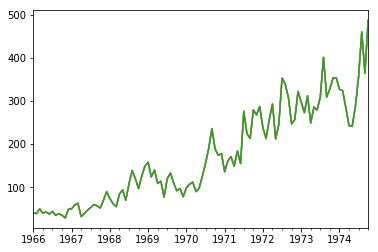

In [28]:
#Data Analysis. Here we look at the data from 4 perpsctive
#Summary stat, Line plots, Density plots and Box/whisker plots
from matplotlib import pyplot
seriez.describe() # from the decription, the SD (avg spread from the mean) is relatively large at 112 roberies
        #the percentile with the SD also suggest a large spread, this will likely make an accurate prediction difficult
seriez.plot() # from these obs, there is obvious trend in the data, we need modeling and removing it.
pyplot.show() #Alternatively, we could use differencing (2 level if there is growth trend) to make series stationary.

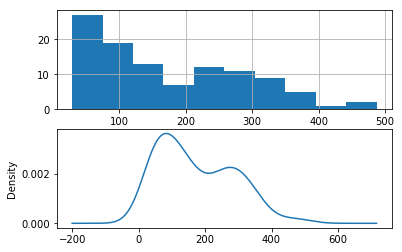

In [30]:
#we can do density plot
pyplot.figure(1)
pyplot.subplot(211)
seriez.hist()
pyplot.subplot(212)
seriez.plot(kind='kde') #the distribution is not gaussian. Maybe, double-sided or explonensial 
pyplot.show()

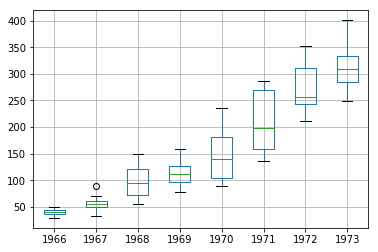

In [38]:
#Plotting the time series box-plot
from pandas import DataFrame
from pandas import TimeGrouper
#from matplotlib import pyplot
#from pandas import Series
#seriez = Series.from_csv('dataset.csv')
groups = seriez['1966':'1973'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
pyplot.show()

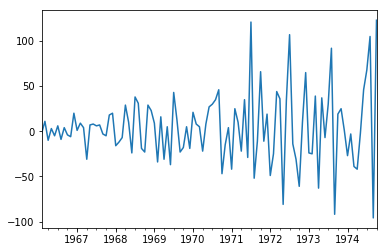

In [48]:
#ARIMA model manual development. Here we are manually configuring ARIMA, using GS to find an optimised model,
#further analyse forcecast residual errors for bias eval in the model and finally improve the model using power transforms
from statsmodels.tsa.stattools import adfuller
#Create a differenced time series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
#difference data
stationary = difference(X)
stationary.index = seriez.index[1:]
#check for stationary
result = adfuller(stationary)
('ADF Statistics: %f' %result[0])
('p-value: %f' % result[1])
('Critical Values:')
for key, value in result[4].items():
    ('\t%s: %.3f' % (key, value))
stationary.to_csv('stationary.csv')
stationary.plot()
pyplot.show()


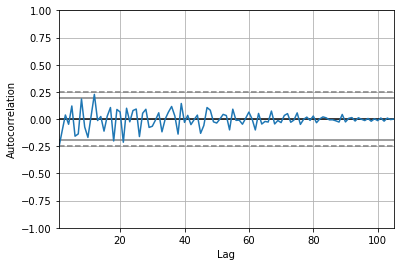

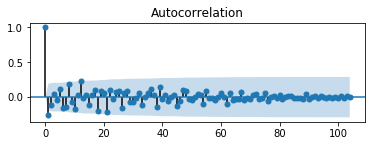

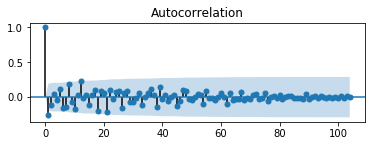

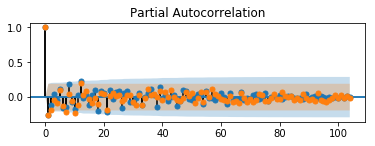

In [55]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
seriex = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(seriex, ax=pyplot.gca())
plot_pacf(seriex, ax=pyplot.gca())
pyplot.show()

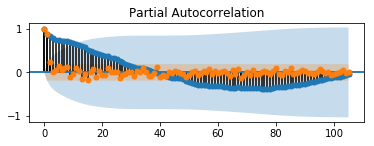

In [57]:
seriex = Series.from_csv('dataset.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(seriex, ax=pyplot.gca())
plot_pacf(seriex, ax=pyplot.gca())
pyplot.show()

In [65]:
#Putting everything together
import warnings
from math import sqrt
from pandas import Series
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
#A fxn to evaluate an ARIMA model
def evaluate_arima_model(X, arima_order):
    #prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #make prediction
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    #calculate for out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
    
#A complete procedure for evaluating a grid of ARIMA hyperparameters
#evaluates the combination of p, d, q values for an ARIMA model
def evaluate_models(stationary, p_values, d_values, q_values):
    stationary = stationary.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(stationary, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f%' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
#Load dataset
seriec = Series.from_csv('stationary.csv') 
#series = read_csv('stationary.csv', header=0)

#Evaluate hyperparameters
p_values = (0, 13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(seriec.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


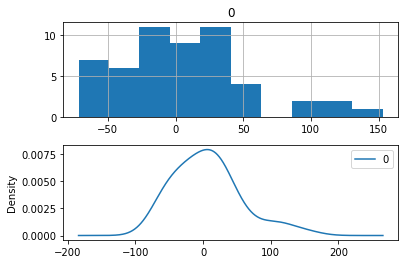

In [69]:
#review residual error
from pandas import Series
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
station = Series.from_csv('stationary.csv')
X = station.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(0, 0, 2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()
#the plot suggest a Gaussian-like distri with long tail | the prediction is biased. In this case a power-based transform
#of the raw data before modelling might be useful

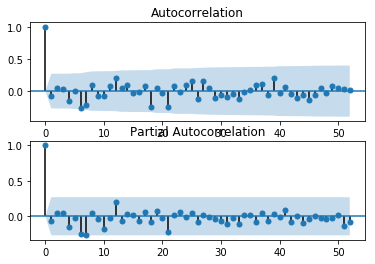

In [70]:
#checking the t.s for any type of autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

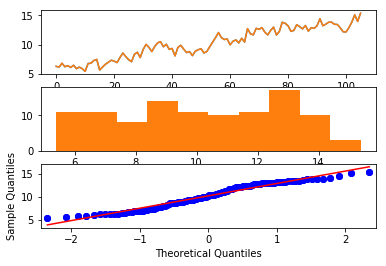

In [76]:
from pandas import Series
from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
serie = Series.from_csv('dataset.csv')
X = serie.values
transformed, lam = boxcox(X)
('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram30.6. ARIMA Models
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [80]:
#Implementing Boc-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

178482300.96318725

In [86]:
#since the Q-Q-plot the boxcox is not a perfect fit for a Gaussian distribution, power transformed (lambda) is further applied
#to improve accuracy by inverting the boxcox. the lambda is implememnted thus. Lambda value of 1 is assumed no transform
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
#walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    tranformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    #predict
    model = ARIMA(tranformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    #implemet the inverse transformed
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    #observation
    obs = test[i]
    print('>Predicted=%.3f, Expected=%3.f ' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

 >Predicted=104.062, Expected=125 
 >Predicted=104.062, Expected=155 
 >Predicted=104.062, Expected=190 
 >Predicted=104.062, Expected=236 
 >Predicted=104.062, Expected=189 
 >Predicted=104.062, Expected=174 
 >Predicted=104.062, Expected=178 
 >Predicted=104.062, Expected=136 
 >Predicted=104.062, Expected=161 
 >Predicted=104.062, Expected=171 
 >Predicted=104.062, Expected=149 
 >Predicted=104.062, Expected=184 
 >Predicted=104.062, Expected=155 
 >Predicted=104.062, Expected=276 
 >Predicted=104.062, Expected=224 
 >Predicted=104.062, Expected=213 
 >Predicted=104.062, Expected=279 
 >Predicted=104.062, Expected=268 
 >Predicted=104.062, Expected=287 
 >Predicted=104.062, Expected=238 
 >Predicted=104.062, Expected=213 
 >Predicted=104.062, Expected=257 
 >Predicted=104.062, Expected=293 
 >Predicted=104.062, Expected=212 
 >Predicted=104.062, Expected=246 
 >Predicted=104.062, Expected=353 
 >Predicted=104.062, Expected=339 
 >Predicted=104.062, Expected=308 
 >Predicted=104.062,

In [88]:
#Model validation
import numpy
#monkey patch around bug in ARIMA class(I don't understand this)
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
transformed, lam = boxcox(X)
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

In [95]:
from statsmodels.tsa.arima_model import ARIMAResults
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 452.043


>Predicted=452.043, Expected=452.000
>Predicted=414.255, Expected=391 
>Predicted=397.183, Expected=500 
>Predicted=475.024, Expected=451 
>Predicted=443.055, Expected=375 
>Predicted=405.172, Expected=372 
>Predicted=405.607, Expected=302 
>Predicted=357.322, Expected=316 
>Predicted=376.677, Expected=398 
>Predicted=410.058, Expected=394 
>Predicted=394.766, Expected=431 
>Predicted=427.014, Expected=431 
RMSE: 51.563


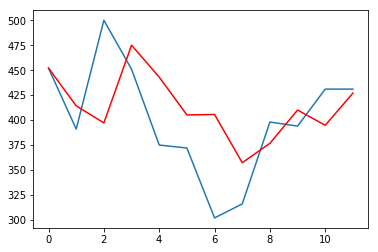

In [98]:
#Model evaluation on the validation dataset. Here we'd use RollingForecast Manner since its a better method and what is 
#used in practice bc of its performance improvemnet
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy
#invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
#load the sliced dataset
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X] #implementation of rollingForecast
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
#load saved model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
#make the first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0])) # this is the predicted on test data and validated (every other data)
#implemeting the rolling forecasts on the validated set
for i in range(1, len(y)):
    #transformed
    transformed, lam = history, 1
    #predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    #invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    #observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f ' % (yhat, obs))
    #report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()